In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## 1. Load All Cleaned Datasets

In [2]:
# Define dataset paths (using absolute paths)
import os
base_path = '/home/anirudh-sharma/Desktop/music-genere-presentation'
datasets = {
    'FMA Small': os.path.join(base_path, 'data/feature-extraction-cleaned/fma_small_features_labeled.csv'),
    'FMA Medium': os.path.join(base_path, 'data/feature-extraction-cleaned/fma_medium_features_labeled.csv'),
    'GTZAN': os.path.join(base_path, 'data/feature-extraction-cleaned/gtzan_features.csv'),
    'Indian Music': os.path.join(base_path, 'data/feature-extraction-cleaned/indian_features.csv'),
    'Ludwig': os.path.join(base_path, 'data/feature-extraction-cleaned/ludwig_features.csv')
}

# Load all datasets
data = {}
for name, path in datasets.items():
    df = pd.read_csv(path)
    data[name] = df
    print(f"✓ Loaded {name}: {df.shape[0]:,} tracks, {df.shape[1]} features")

print(f"\n📊 Total tracks: {sum(df.shape[0] for df in data.values()):,}")

✓ Loaded FMA Small: 7,996 tracks, 76 features
✓ Loaded FMA Medium: 16,986 tracks, 76 features
✓ Loaded GTZAN: 999 tracks, 74 features
✓ Loaded Indian Music: 500 tracks, 75 features
✓ Loaded Ludwig: 11,293 tracks, 75 features

📊 Total tracks: 37,774
✓ Loaded Ludwig: 11,293 tracks, 75 features

📊 Total tracks: 37,774


## 2. Calculate Skewness Scores

**Skewness Interpretation**:
- **|skew| < 0.5**: Fairly symmetric (Normal-like)
- **0.5 ≤ |skew| < 1**: Moderately skewed
- **|skew| ≥ 1**: Highly skewed (transformation recommended)

In [3]:
def calculate_skewness(df, dataset_name):
    """
    Calculate skewness for all numerical features.
    Returns a DataFrame with skewness scores sorted by absolute value.
    """
    # Select only numerical columns (exclude metadata columns)
    exclude_cols = ['file_path', 'dataset', 'label', 'subset', 'duration', 'sr']
    numerical_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Calculate skewness
    skewness = df[numerical_cols].skew().sort_values(ascending=False)
    
    # Create DataFrame with skewness values
    skew_df = pd.DataFrame({
        'Feature': skewness.index,
        'Skewness': skewness.values,
        'Abs_Skewness': np.abs(skewness.values),
        'Dataset': dataset_name
    })
    
    # Add severity classification
    skew_df['Severity'] = skew_df['Abs_Skewness'].apply(
        lambda x: 'HIGH' if x >= 1 else ('MODERATE' if x >= 0.5 else 'LOW')
    )
    
    return skew_df.sort_values('Abs_Skewness', ascending=False)

# Calculate skewness for all datasets
skewness_results = {}
for name, df in data.items():
    skewness_results[name] = calculate_skewness(df, name)
    print(f"\n{'='*70}")
    print(f"📊 {name} - Top 10 Most Skewed Features")
    print(f"{'='*70}")
    print(skewness_results[name].head(10).to_string(index=False))


📊 FMA Small - Top 10 Most Skewed Features
   Feature  Skewness  Abs_Skewness   Dataset Severity
  zcr_mean  2.067577      2.067577 FMA Small     HIGH
mfcc15_std  1.495236      1.495236 FMA Small     HIGH
mfcc14_std  1.412661      1.412661 FMA Small     HIGH
mfcc20_std  1.380319      1.380319 FMA Small     HIGH
mfcc19_std  1.327222      1.327222 FMA Small     HIGH
mfcc17_std  1.315141      1.315141 FMA Small     HIGH
mfcc16_std  1.303042      1.303042 FMA Small     HIGH
mfcc18_std  1.292686      1.292686 FMA Small     HIGH
mfcc12_std  1.207877      1.207877 FMA Small     HIGH
mfcc13_std  1.165850      1.165850 FMA Small     HIGH

📊 FMA Medium - Top 10 Most Skewed Features
   Feature  Skewness  Abs_Skewness    Dataset Severity
  zcr_mean  1.984903      1.984903 FMA Medium     HIGH
mfcc16_std  1.691048      1.691048 FMA Medium     HIGH
mfcc20_std  1.677982      1.677982 FMA Medium     HIGH
mfcc19_std  1.656438      1.656438 FMA Medium     HIGH
mfcc15_std  1.596505      1.596505 FMA Mediu

## 3. Combined Skewness Analysis Across All Datasets

In [4]:
# Combine all skewness results
combined_skewness = pd.concat(skewness_results.values(), ignore_index=True)

# Calculate average skewness per feature across all datasets
avg_skewness = combined_skewness.groupby('Feature').agg({
    'Skewness': 'mean',
    'Abs_Skewness': 'mean'
}).reset_index()

avg_skewness['Avg_Severity'] = avg_skewness['Abs_Skewness'].apply(
    lambda x: 'HIGH' if x >= 1 else ('MODERATE' if x >= 0.5 else 'LOW')
)

# Sort by absolute skewness
avg_skewness = avg_skewness.sort_values('Abs_Skewness', ascending=False)

print("\n" + "="*70)
print("🎯 TOP 10 MOST SKEWED FEATURES (Averaged Across All Datasets)")
print("="*70)
print(avg_skewness.head(10).to_string(index=False))

# Count features by severity
severity_counts = avg_skewness['Avg_Severity'].value_counts()
print("\n" + "="*70)
print("📈 Feature Skewness Distribution")
print("="*70)
print(f"HIGH Skewness (|skew| ≥ 1.0): {severity_counts.get('HIGH', 0)} features")
print(f"MODERATE Skewness (0.5 ≤ |skew| < 1.0): {severity_counts.get('MODERATE', 0)} features")
print(f"LOW Skewness (|skew| < 0.5): {severity_counts.get('LOW', 0)} features")
print(f"\nTotal features analyzed: {len(avg_skewness)}")


🎯 TOP 10 MOST SKEWED FEATURES (Averaged Across All Datasets)
   Feature  Skewness  Abs_Skewness Avg_Severity
mfcc14_std  1.545483      1.545483         HIGH
mfcc16_std  1.495998      1.495998         HIGH
mfcc15_std  1.492849      1.492849         HIGH
mfcc17_std  1.378252      1.378252         HIGH
mfcc20_std  1.328536      1.328536         HIGH
mfcc13_std  1.308589      1.308589         HIGH
mfcc11_std  1.291862      1.291862         HIGH
mfcc12_std  1.266216      1.266216         HIGH
mfcc18_std  1.263306      1.263306         HIGH
mfcc19_std  1.241649      1.241649         HIGH

📈 Feature Skewness Distribution
HIGH Skewness (|skew| ≥ 1.0): 11 features
MODERATE Skewness (0.5 ≤ |skew| < 1.0): 17 features
LOW Skewness (|skew| < 0.5): 42 features

Total features analyzed: 70


## 4. Visualize Distribution Shapes

### 4.1 Key Spectral Features: spec_rolloff_mean and spec_centroid_mean

In [5]:
# Create output directory
output_dir = os.path.join(base_path, 'results/step1.4-distribution-skewness')
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Results will be saved to: {output_dir}")

📁 Results will be saved to: /home/anirudh-sharma/Desktop/music-genere-presentation/results/step1.4-distribution-skewness



📊 Generating distribution plots...

✓ Saved: distribution_spec-rolloff-mean.png
✓ Saved: distribution_spec-rolloff-mean.png


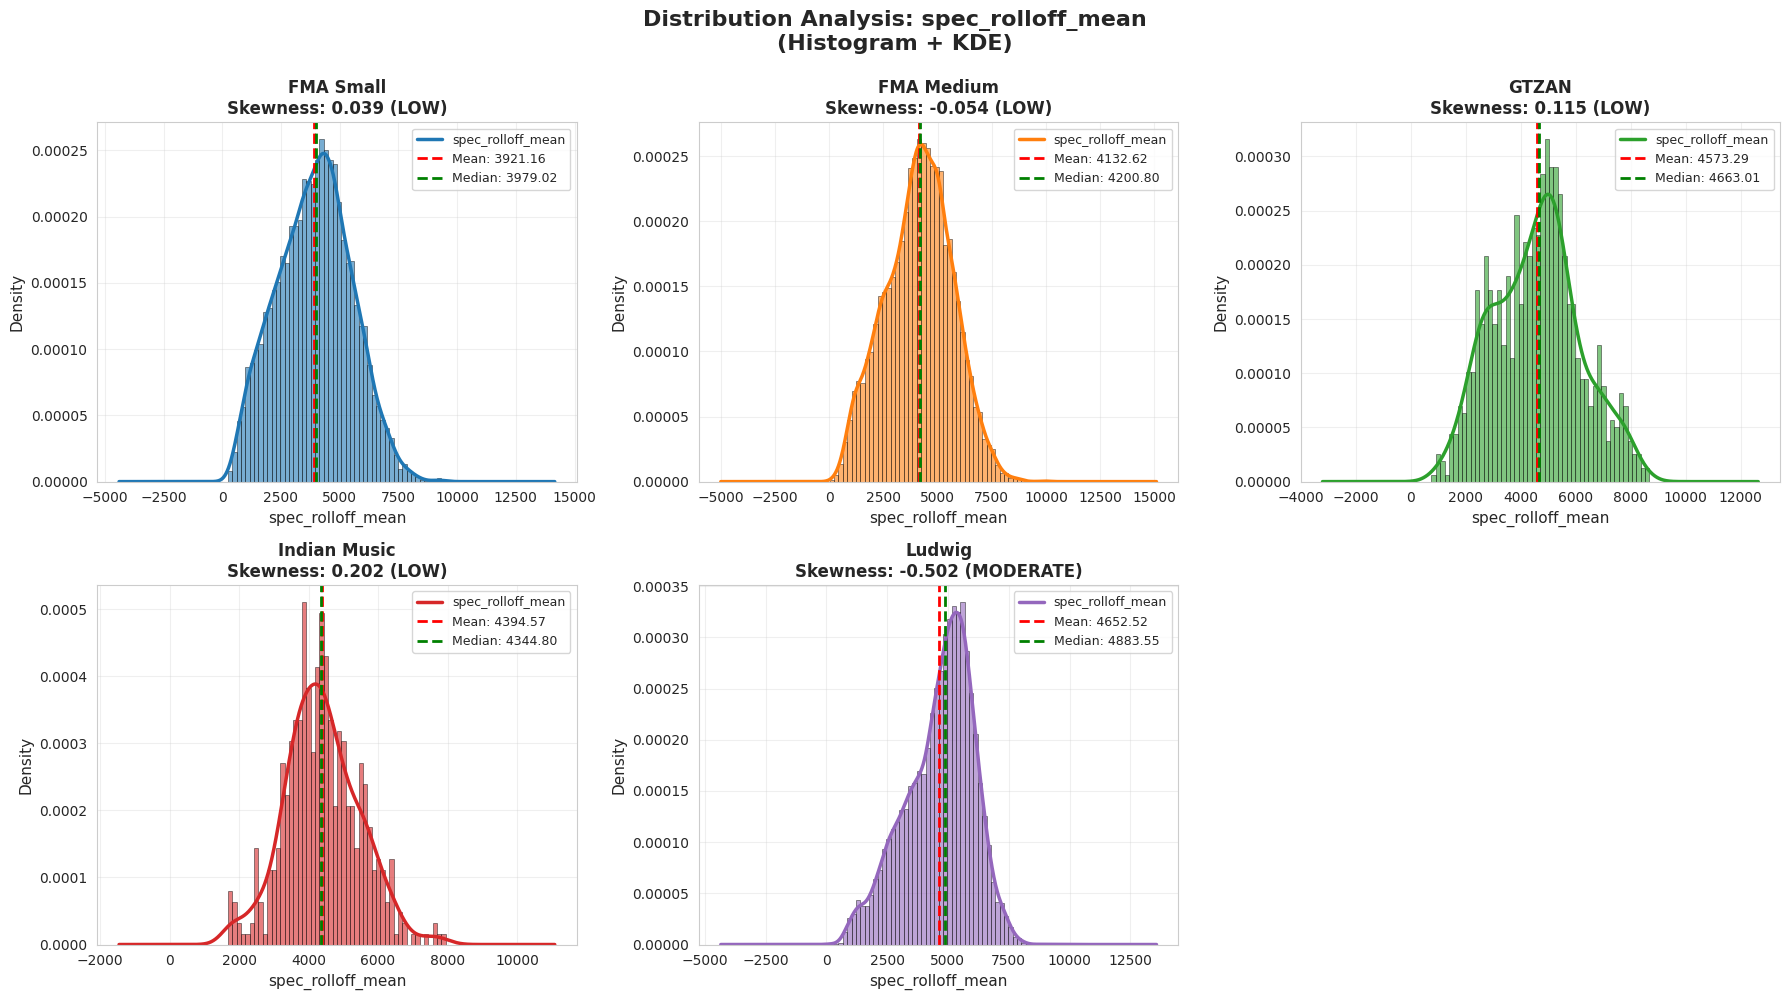

✓ Saved: distribution_spec-centroid-mean.png


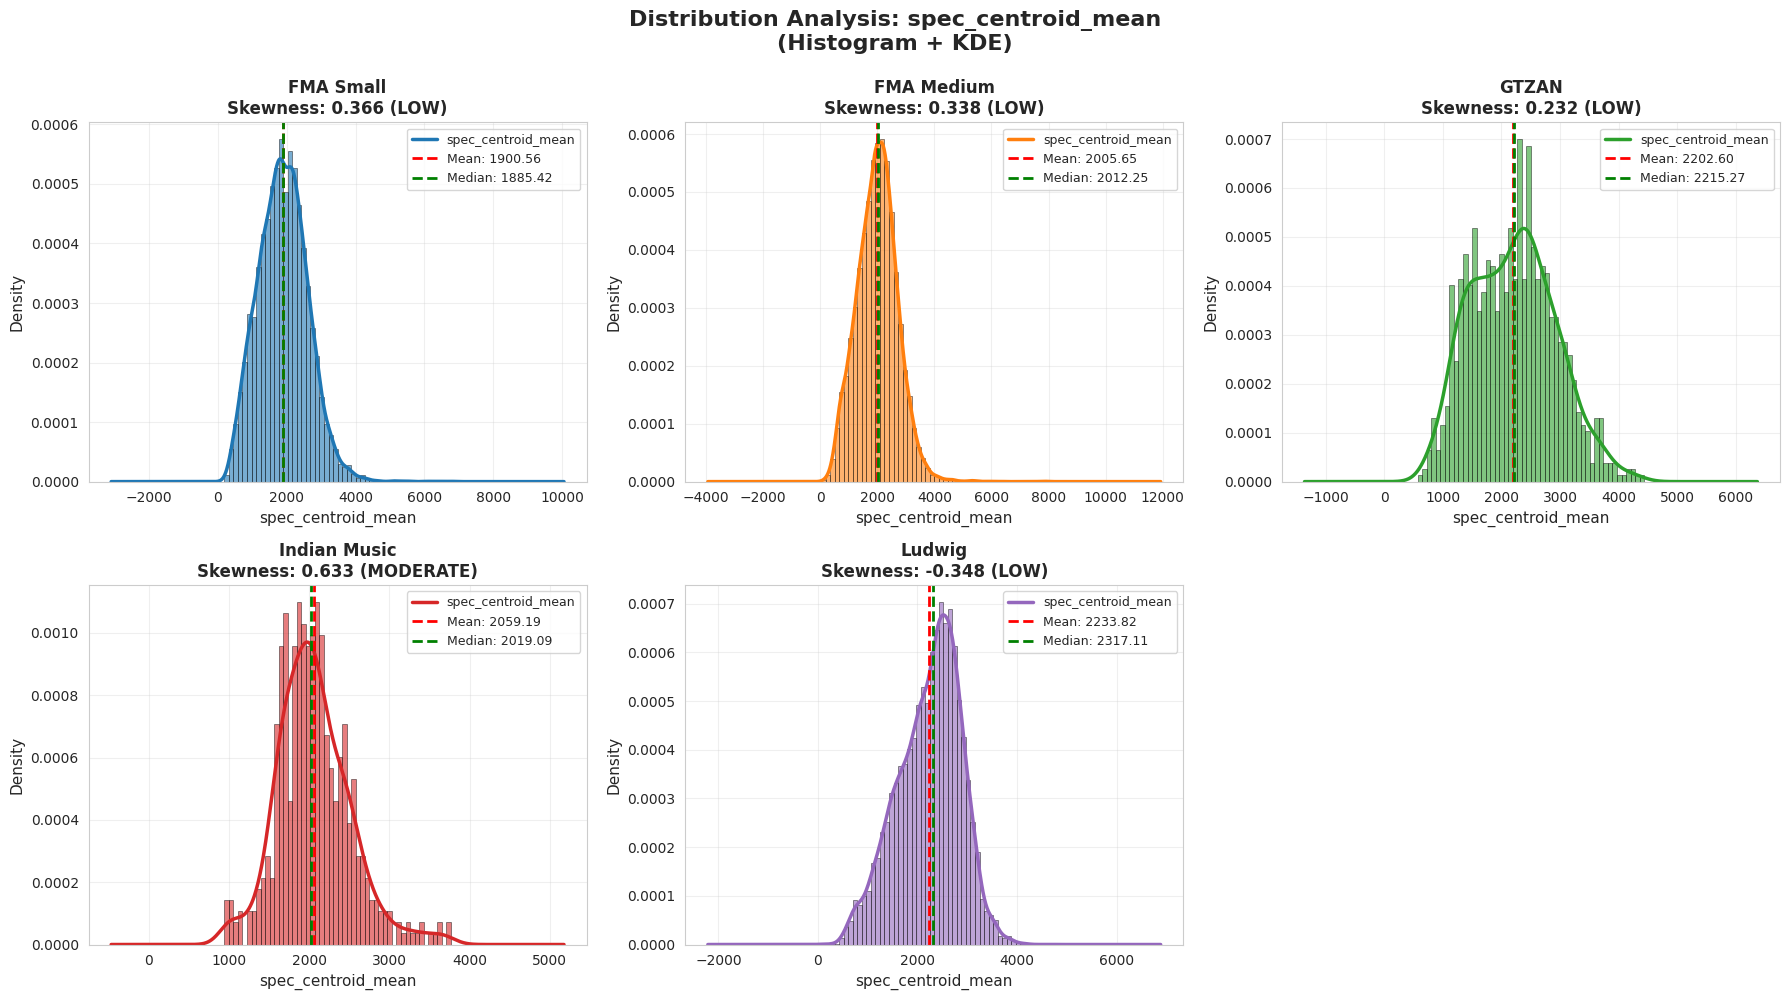

In [6]:
def plot_distribution_comparison(feature_name, datasets_dict, output_dir):
    """
    Plot histogram + KDE for a specific feature across all datasets.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for idx, (name, df) in enumerate(datasets_dict.items()):
        ax = axes[idx]
        
        # Get feature data
        data_values = df[feature_name].dropna()
        
        # Calculate skewness
        skew_value = stats.skew(data_values)
        
        # Plot histogram with KDE
        ax.hist(data_values, bins=50, alpha=0.6, color=colors[idx], 
                density=True, edgecolor='black', linewidth=0.5)
        
        # Plot KDE
        data_values.plot(kind='kde', ax=ax, color=colors[idx], linewidth=2.5)
        
        # Add vertical line for mean
        mean_val = data_values.mean()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_val:.2f}')
        
        # Add vertical line for median
        median_val = data_values.median()
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, 
                   label=f'Median: {median_val:.2f}')
        
        # Title and labels
        severity = 'HIGH' if abs(skew_value) >= 1 else ('MODERATE' if abs(skew_value) >= 0.5 else 'LOW')
        ax.set_title(f"{name}\nSkewness: {skew_value:.3f} ({severity})", 
                     fontsize=12, fontweight='bold')
        ax.set_xlabel(feature_name, fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    # Remove extra subplot
    axes[-1].axis('off')
    
    plt.suptitle(f'Distribution Analysis: {feature_name}\n(Histogram + KDE)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save figure
    filename = f"distribution_{feature_name.replace('_', '-')}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {filename}")
    plt.show()

# Plot distributions for key spectral features
print("\n📊 Generating distribution plots...\n")
plot_distribution_comparison('spec_rolloff_mean', data, output_dir)
plot_distribution_comparison('spec_centroid_mean', data, output_dir)

### 4.2 Additional Key Features: tempo and rms_mean

✓ Saved: distribution_tempo.png


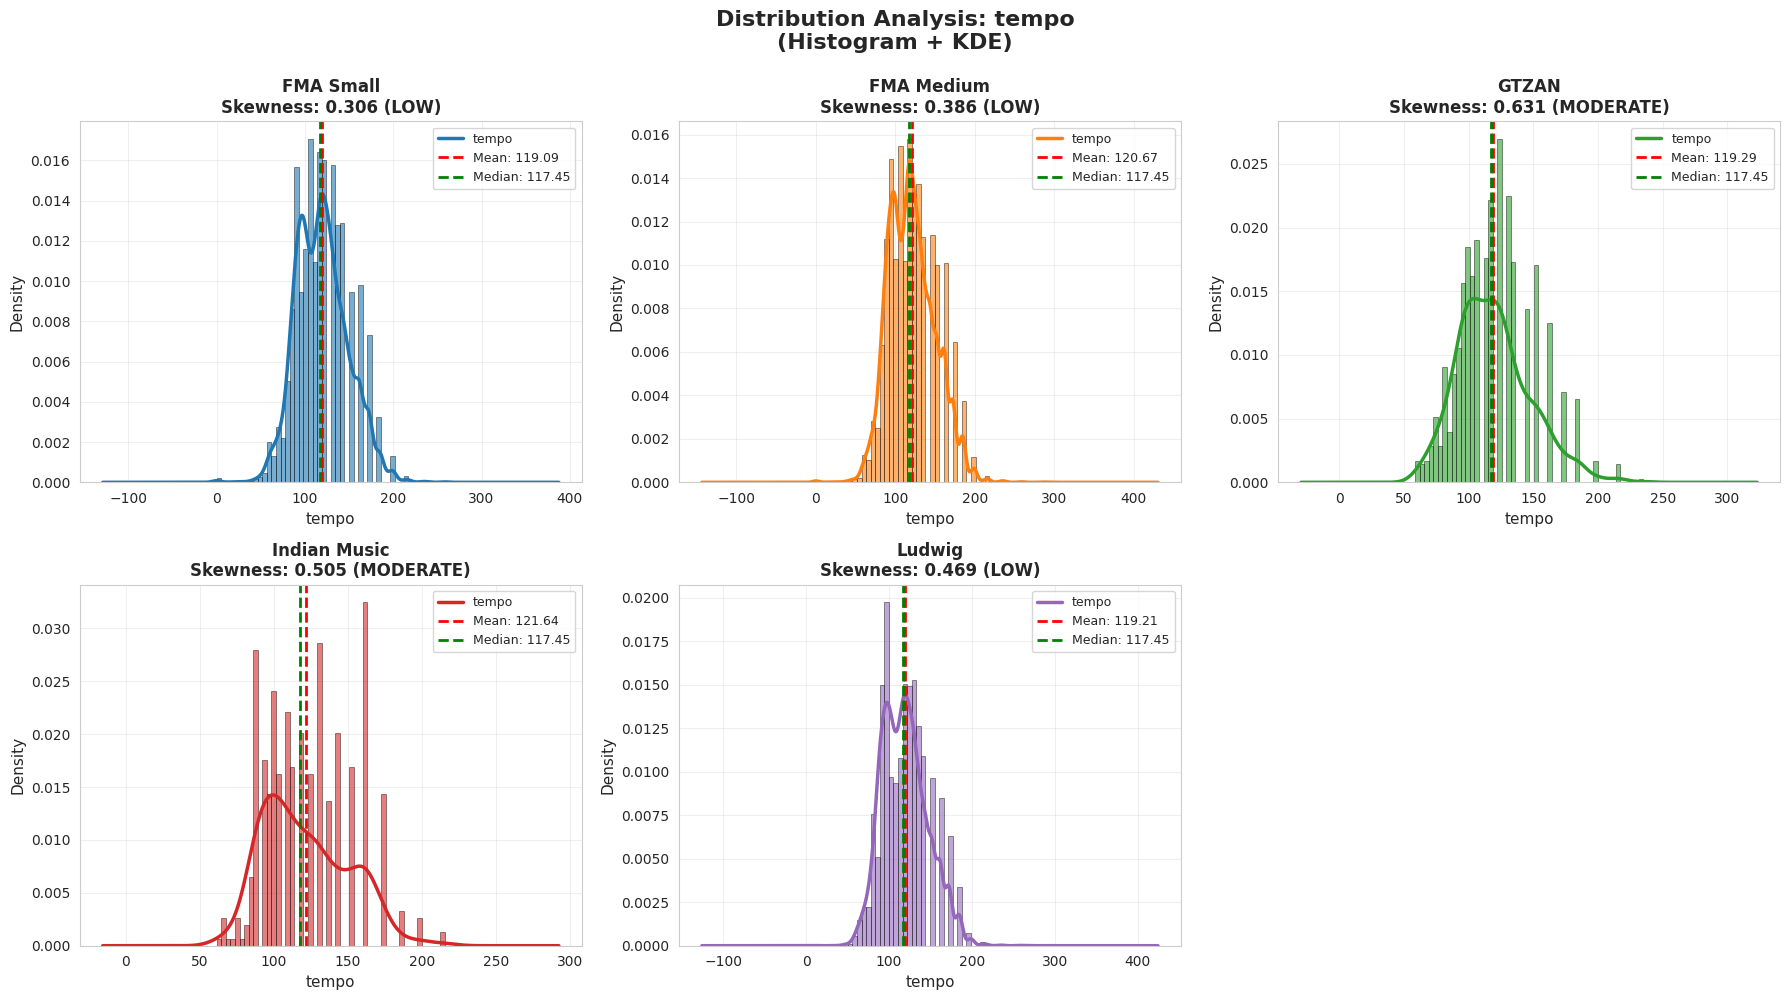

✓ Saved: distribution_rms-mean.png


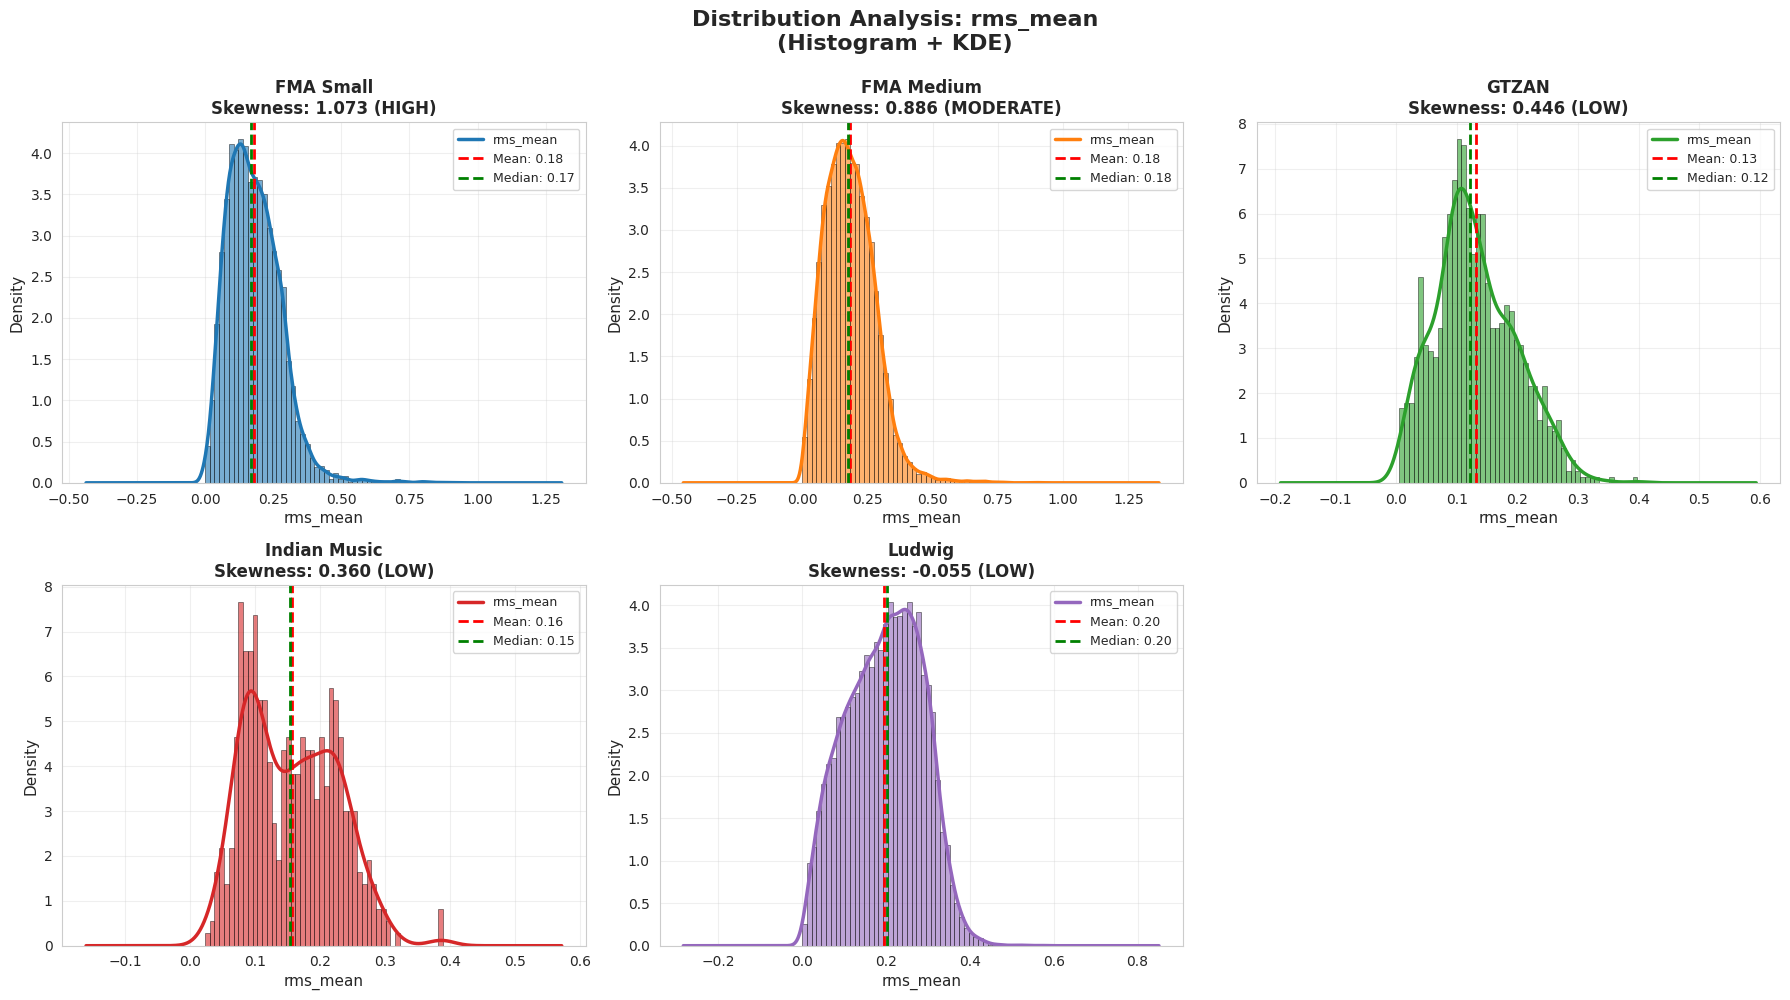

In [7]:
# Plot distributions for additional important features
plot_distribution_comparison('tempo', data, output_dir)
plot_distribution_comparison('rms_mean', data, output_dir)

## 5. Skewness Heatmap Across Datasets


✓ Saved: skewness_heatmap.png


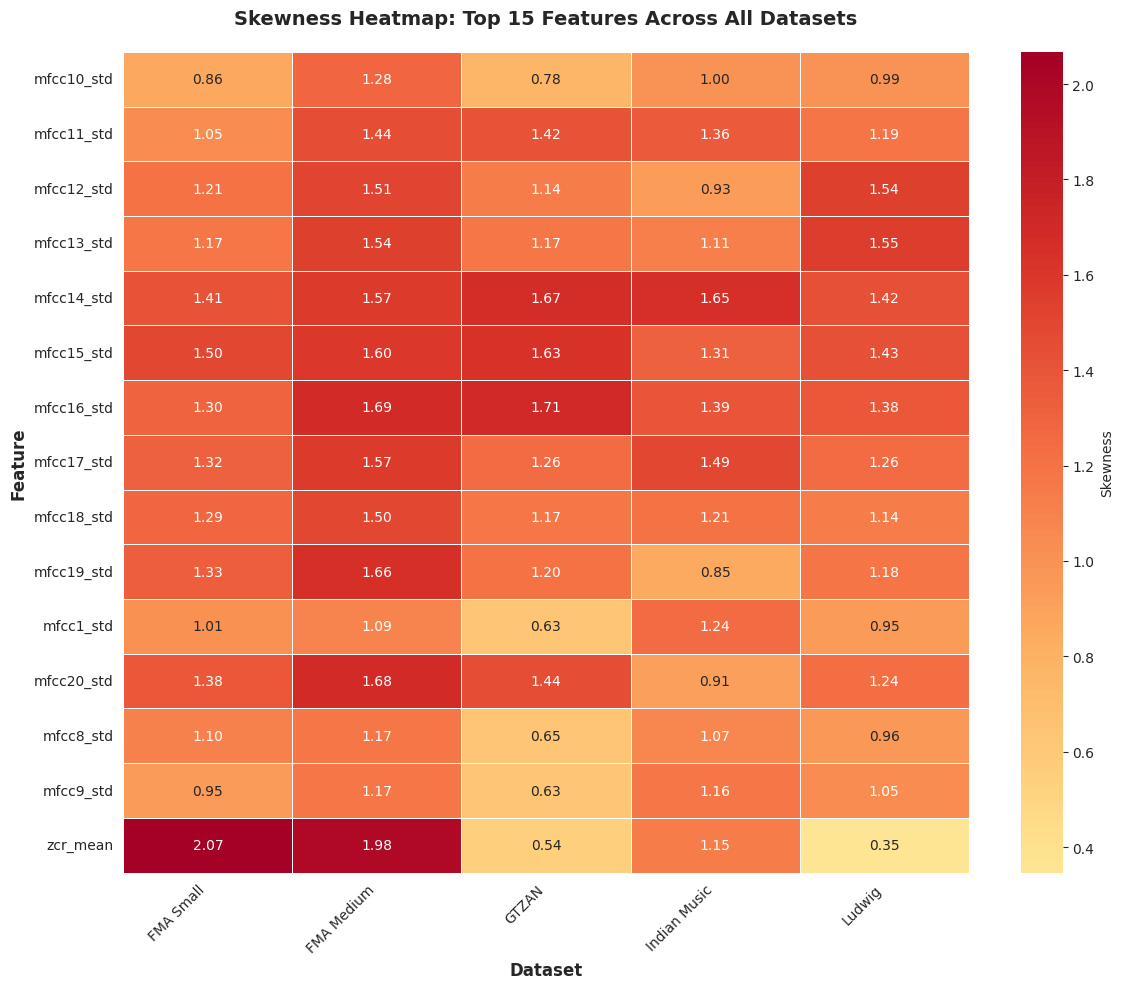

In [8]:
# Get top 15 most skewed features on average
top_features = avg_skewness.head(15)['Feature'].tolist()

# Create a pivot table for heatmap
heatmap_data = combined_skewness[combined_skewness['Feature'].isin(top_features)].pivot(
    index='Feature', columns='Dataset', values='Skewness'
)

# Reorder datasets
dataset_order = ['FMA Small', 'FMA Medium', 'GTZAN', 'Indian Music', 'Ludwig']
heatmap_data = heatmap_data[dataset_order]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            center=0, linewidths=0.5, cbar_kws={'label': 'Skewness'})
plt.title('Skewness Heatmap: Top 15 Features Across All Datasets', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save figure
filepath = os.path.join(output_dir, 'skewness_heatmap.png')
plt.savefig(filepath, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: skewness_heatmap.png")
plt.show()

## 6. Comparative Bar Chart: Skewness by Dataset


✓ Saved: dataset_skewness_comparison.png


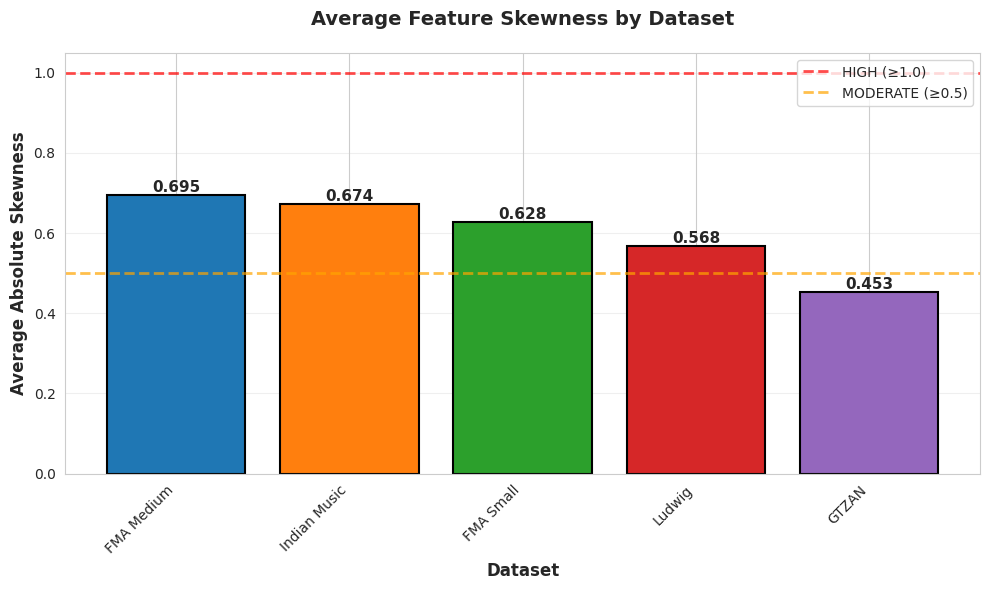

In [9]:
# Calculate average absolute skewness per dataset
dataset_avg_skew = combined_skewness.groupby('Dataset')['Abs_Skewness'].mean().sort_values(ascending=False)

# Plot bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(dataset_avg_skew.index, dataset_avg_skew.values, 
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
              edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add threshold lines
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='HIGH (≥1.0)', alpha=0.7)
ax.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, label='MODERATE (≥0.5)', alpha=0.7)

ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Absolute Skewness', fontsize=12, fontweight='bold')
ax.set_title('Average Feature Skewness by Dataset', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save figure
filepath = os.path.join(output_dir, 'dataset_skewness_comparison.png')
plt.savefig(filepath, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: dataset_skewness_comparison.png")
plt.show()

## 7. Save Skewness Results to CSV

In [10]:
# Save combined skewness results
combined_skewness_file = os.path.join(output_dir, 'skewness_all_datasets.csv')
combined_skewness.to_csv(combined_skewness_file, index=False)
print(f"✓ Saved: skewness_all_datasets.csv")

# Save average skewness results
avg_skewness_file = os.path.join(output_dir, 'skewness_average.csv')
avg_skewness.to_csv(avg_skewness_file, index=False)
print(f"✓ Saved: skewness_average.csv")

# Save individual dataset results
for name, skew_df in skewness_results.items():
    filename = f"skewness_{name.lower().replace(' ', '_')}.csv"
    filepath = os.path.join(output_dir, filename)
    skew_df.to_csv(filepath, index=False)
    print(f"✓ Saved: {filename}")

✓ Saved: skewness_all_datasets.csv
✓ Saved: skewness_average.csv
✓ Saved: skewness_fma_small.csv
✓ Saved: skewness_fma_medium.csv
✓ Saved: skewness_gtzan.csv
✓ Saved: skewness_indian_music.csv
✓ Saved: skewness_ludwig.csv


## 8. Analysis Summary & Recommendations

In [11]:
print("\n" + "="*80)
print("📋 PHASE 3: DISTRIBUTION & SKEWNESS ANALYSIS - SUMMARY")
print("="*80)

# Overall statistics
total_features = len(avg_skewness)
high_skew = len(avg_skewness[avg_skewness['Avg_Severity'] == 'HIGH'])
moderate_skew = len(avg_skewness[avg_skewness['Avg_Severity'] == 'MODERATE'])
low_skew = len(avg_skewness[avg_skewness['Avg_Severity'] == 'LOW'])

print(f"\n📊 FEATURE DISTRIBUTION ANALYSIS:")
print(f"   • Total features analyzed: {total_features}")
print(f"   • HIGH skewness (|skew| ≥ 1.0): {high_skew} features ({high_skew/total_features*100:.1f}%)")
print(f"   • MODERATE skewness (0.5 ≤ |skew| < 1.0): {moderate_skew} features ({moderate_skew/total_features*100:.1f}%)")
print(f"   • LOW skewness (|skew| < 0.5): {low_skew} features ({low_skew/total_features*100:.1f}%)")

# Top 5 most skewed features
print(f"\n🎯 TOP 5 MOST SKEWED FEATURES:")
for idx, row in avg_skewness.head(5).iterrows():
    print(f"   {idx+1}. {row['Feature']}: {row['Skewness']:.3f} ({row['Avg_Severity']})")

# Key spectral features
key_features = ['spec_rolloff_mean', 'spec_centroid_mean', 'tempo', 'rms_mean', 'zcr_mean']
print(f"\n🔑 KEY FEATURES FOR K-MEANS:")
for feature in key_features:
    if feature in avg_skewness['Feature'].values:
        row = avg_skewness[avg_skewness['Feature'] == feature].iloc[0]
        print(f"   • {feature}: {row['Skewness']:.3f} ({row['Avg_Severity']})")

# Recommendations
print(f"\n💡 RECOMMENDATIONS:")
if high_skew > total_features * 0.3:
    print(f"   ⚠️  Log transformation is STRONGLY RECOMMENDED")
    print(f"   ⚠️  {high_skew} features ({high_skew/total_features*100:.1f}%) show high skewness")
    print(f"   ⚠️  Power Law distributions detected - will negatively impact K-Means")
elif moderate_skew + high_skew > total_features * 0.5:
    print(f"   ⚡ Log transformation is RECOMMENDED")
    print(f"   ⚡ {moderate_skew + high_skew} features show moderate-to-high skewness")
    print(f"   ⚡ Transformation will improve K-Means clustering quality")
else:
    print(f"   ✓ Data distributions are relatively symmetric")
    print(f"   ✓ Log transformation is OPTIONAL")
    print(f"   ✓ StandardScaler normalization may be sufficient")

print(f"\n📈 NEXT STEPS:")
print(f"   1. Apply Log transformation to features with |skew| ≥ 1.0")
print(f"   2. Re-evaluate skewness after transformation")
print(f"   3. Proceed to normalization (StandardScaler or RobustScaler)")
print(f"   4. Continue with PCA dimensionality reduction")

print("\n" + "="*80)
print("✅ PHASE 3 COMPLETE: Distribution & Skewness Analysis")
print("="*80)


📋 PHASE 3: DISTRIBUTION & SKEWNESS ANALYSIS - SUMMARY

📊 FEATURE DISTRIBUTION ANALYSIS:
   • Total features analyzed: 70
   • HIGH skewness (|skew| ≥ 1.0): 11 features (15.7%)
   • MODERATE skewness (0.5 ≤ |skew| < 1.0): 17 features (24.3%)
   • LOW skewness (|skew| < 0.5): 42 features (60.0%)

🎯 TOP 5 MOST SKEWED FEATURES:
   34. mfcc14_std: 1.545 (HIGH)
   38. mfcc16_std: 1.496 (HIGH)
   36. mfcc15_std: 1.493 (HIGH)
   40. mfcc17_std: 1.378 (HIGH)
   48. mfcc20_std: 1.329 (HIGH)

🔑 KEY FEATURES FOR K-MEANS:
   • spec_rolloff_mean: -0.040 (LOW)
   • spec_centroid_mean: 0.245 (LOW)
   • tempo: 0.460 (LOW)
   • rms_mean: 0.543 (MODERATE)
   • zcr_mean: 1.217 (HIGH)

💡 RECOMMENDATIONS:
   ✓ Data distributions are relatively symmetric
   ✓ Log transformation is OPTIONAL
   ✓ StandardScaler normalization may be sufficient

📈 NEXT STEPS:
   1. Apply Log transformation to features with |skew| ≥ 1.0
   2. Re-evaluate skewness after transformation
   3. Proceed to normalization (StandardScale